#### SUMMARY
evaluate trained model

#### ISSUES
1. currently ImageTupleeList has error on _repr_()

In [1]:
import os
import sys
from pathlib import Path
PATH = os.path.join(os.getcwd(), '..', '..')
sys.path.append(PATH)

import torch
import numpy as np
import matplotlib.pyplot as plt

from fastai.vision import *

from src.model_utils.cyclegan import CycleGAN
from src.model_utils.databunch import ImageTupleList
from src.model_utils.callbacks import CycleGANTrainer
from src.model_utils.loss import CycleGanLoss

%matplotlib inline
%load_ext autoreload
%autoreload

#### 0. Pick Easy Dataset or Medium Dataset

In [4]:
easy_path = Path('../../data/easy')
medium_path = Path('../../data/medium')
easy_model = 'easy_100fit'
medium_model = 'medium_100fit'

In [5]:
path = medium_path
model = medium_model

In [22]:
easy_data = (ImageTupleList.from_folders(easy_path, 'trainA', 'trainB')
                      .split_none()
                      .label_empty()
                      .transform(get_transforms(), size = 56)
                      .databunch(bs=4))

#### 1. Load in Dataset and Trained Model

In [6]:
data = (ImageTupleList.from_folders(path, 'trainA', 'trainB')
                      .split_none()
                      .label_empty()
                      .transform(get_transforms(), size = 56)
                      .databunch(bs=4))

In [7]:
cycle_gan = CycleGAN(3,3, gen_blocks=9)

In [8]:
learn = Learner(data, cycle_gan, loss_func = CycleGanLoss(cycle_gan), 
                opt_func = partial(optim.Adam, betas = (0.5,0.99)), 
                callback_fns = [CycleGANTrainer])

In [9]:
learn = learn.load(model)

#### 2. Inspect Examples

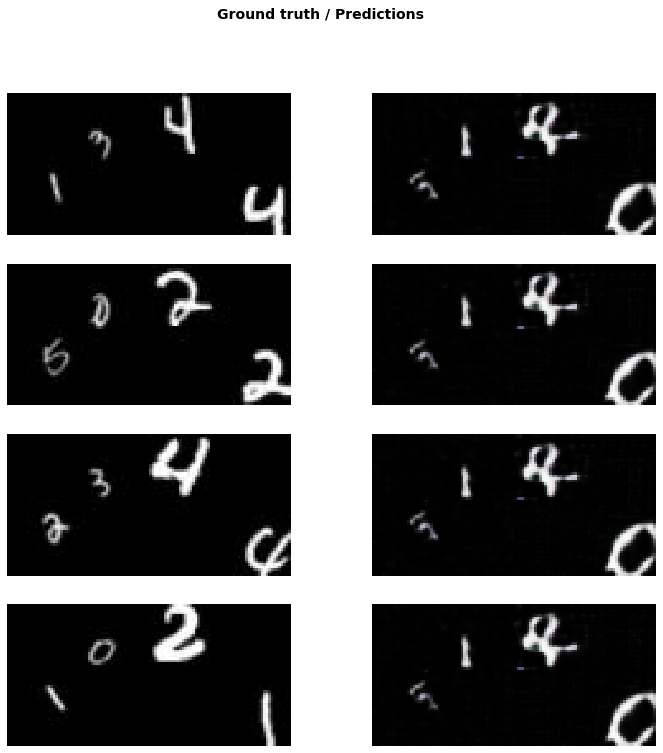

In [10]:
learn.show_results(ds_type = DatasetType.Train, rows = 2)

#### 3. Select Best and Worst Samples (Sorted by Loss)

In [11]:
len(learn.data.train_ds.items), len(learn.data.train_ds.itemsB)

(12000, 12000)

In [12]:
def get_batch(filenames, tfms, **kwargs):
    samples = [open_image(fn) for fn in filenames]
    for s in samples: s = s.apply_tfms(tfms, **kwargs)
    batch = torch.stack([s.data for s in samples], 0).cuda()
    return 2. * (batch - 0.5)

In [13]:
learn.model.eval()
tfms = get_transforms()[1]
bs = 16

def get_losses(fnames, gen, crit, bs = 16):
    losses_in, losses_out = [], []
    with torch.no_grad():
        for i in progress_bar(range(0, len(fnames), bs)):
            xb = get_batch(fnames[i: i + bs], tfms, size = 56)
            fakes = gen(xb)
            preds_in, preds_out = crit(xb), crit(fakes)
            loss_in = learn.loss_func.crit(preds_in, True, reduction = 'none')
            loss_out = learn.loss_func.crit(preds_out, True, reduction = 'none')
            losses_in.append(loss_in.view(loss_in.size(0), -1).mean(1))
            losses_out.append(loss_out.view(loss_out.size(0), -1).mean(1))
    return torch.cat(losses_in), torch.cat(losses_out)

In [14]:
# translate from domain A to B
losses_A = get_losses(data.train_ds.x.items, learn.model.G_B, learn.model.D_B)
# translate from domain B to A
losses_B = get_losses(data.train_ds.x.itemsB, learn.model.G_A, learn.model.D_A)

In [15]:
def show_top(fnames, losses, gen, n = 4, descending = True):
    sort_idx = losses.argsort(descending = descending)
    _,axs = plt.subplots(n//2, 4, figsize=(12,2*n))
    xb = get_batch(fnames[sort_idx][:n], tfms, size=128)
    with torch.no_grad():
        fakes = gen(xb)
    xb,fakes = (1+xb.cpu())/2,(1+fakes.cpu())/2
    for i in range(n):
        axs.flatten()[2*i].imshow(xb[i].permute(1,2,0))
        axs.flatten()[2*i].axis('off')
        axs.flatten()[2*i+1].imshow(fakes[i].permute(1,2,0))
        axs.flatten()[2*i+1].set_title(losses[sort_idx][i].item())
        axs.flatten()[2*i+1].axis('off')

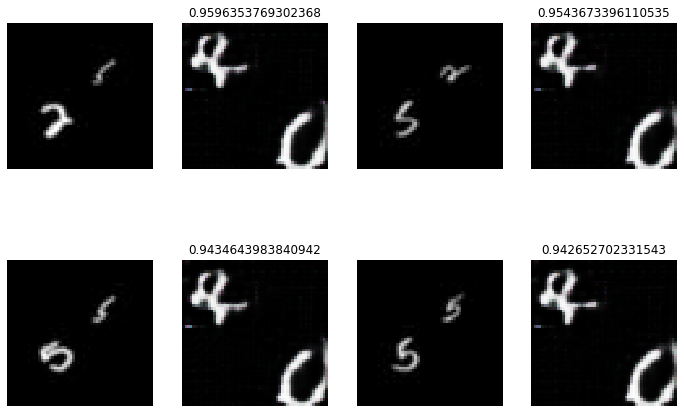

In [16]:
show_top(data.train_ds.x.items, 
         losses_A[1].cpu(), learn.model.G_B, 
         n = 4, descending = True)

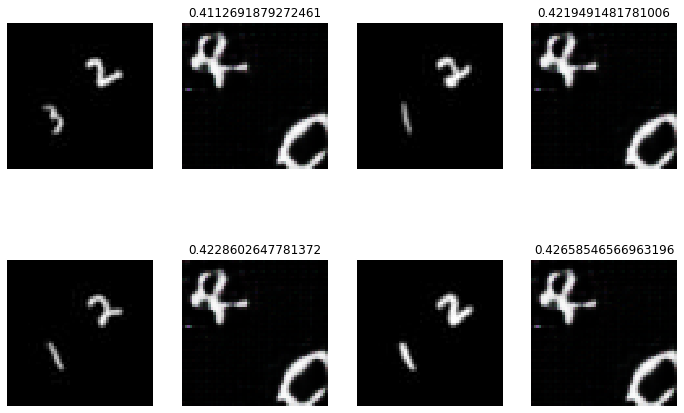

In [17]:
show_top(data.train_ds.x.items, 
         losses_A[1].cpu(), learn.model.G_B, 
         n = 4, descending = False)

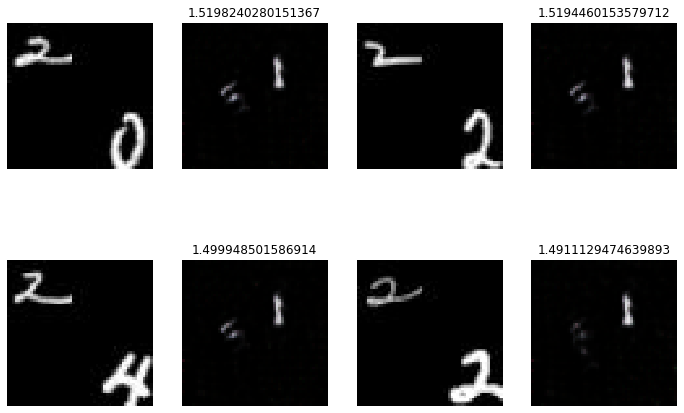

In [18]:
show_top(data.train_ds.x.itemsB,
         losses_B[1].cpu(), learn.model.G_A, 
         n = 4, descending = True)

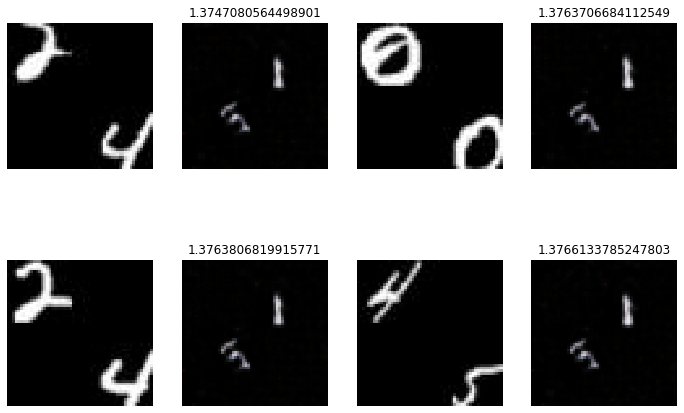

In [19]:
show_top(data.train_ds.x.itemsB,
         losses_B[1].cpu(), learn.model.G_A, 
         n = 4, descending = False)